In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [3]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [4]:
wing_1 = Image.open('../testdata/set_1/043870_L_O.JPG')
wing_2 = Image.open('../testdata/set_1/043870_R_O.JPG')
wing_3 = Image.open('../testdata/set_1/043874_L_O.JPG')
wing_4 = Image.open('../testdata/set_1/043874_R_O.JPG')
wing_5 = Image.open('../testdata/set_1/043878_L_O.JPG')
wing_6 = Image.open('../testdata/set_1/043878_R_O.JPG')
wing_7 = Image.open('../testdata/set_1/043884_L_O.JPG')

wing = wing_2
wing = np.array(wing.convert("RGB"))

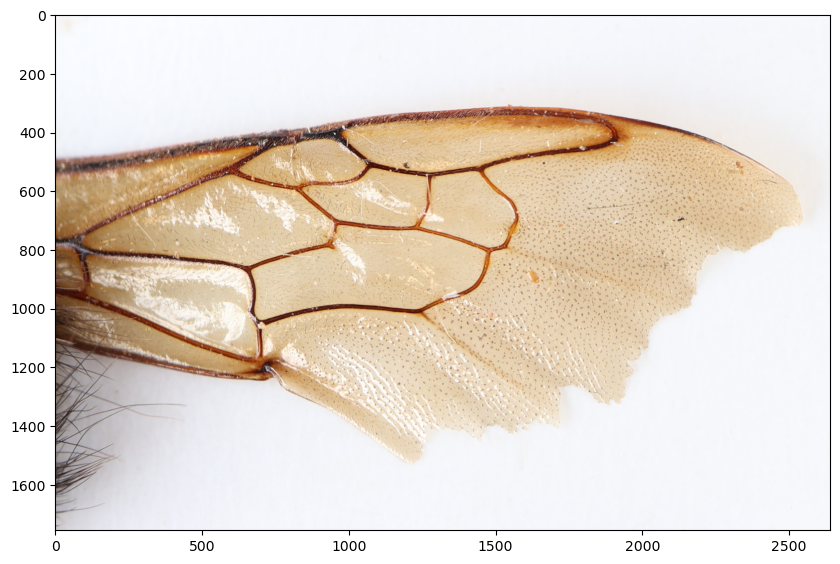

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(wing)
plt.axis('on')
plt.show()

In [11]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "/home/wsl/bin/segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [ ]:
masks2 = mask_generator_2.generate(wing)

/home/wsl/bin/segment-anything-2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/wsl/bin/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(wing)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [ ]:
for i, mask in enumerate(masks2):
    print(f"Size of label {i}:\t{mask['area']} pixels")

In [10]:
?SAM2AutomaticMaskGenerator

Init signature:
SAM2AutomaticMaskGenerator(
    model: sam2.modeling.sam2_base.SAM2Base,
    points_per_side: Optional[int] = 32,
    points_per_batch: int = 64,
    pred_iou_thresh: float = 0.8,
    stability_score_thresh: float = 0.95,
    stability_score_offset: float = 1.0,
    mask_threshold: float = 0.0,
    box_nms_thresh: float = 0.7,
    crop_n_layers: int = 0,
    crop_nms_thresh: float = 0.7,
    crop_overlap_ratio: float = 0.3413333333333333,
    crop_n_points_downscale_factor: int = 1,
    point_grids: Optional[List[numpy.ndarray]] = None,
    min_mask_region_area: int = 0,
    output_mode: str = 'binary_mask',
    use_m2m: bool = False,
    multimask_output: bool = True,
    **kwargs,
) -> None
Docstring:      <no docstring>
Init docstring:
Using a SAM 2 model, generates masks for the entire image.
Generates a grid of point prompts over the image, then filters
low quality and duplicate masks. The default settings are chosen
for SAM 2 with a HieraL backbone.

Arguments:
  